# Explainer

---

## Load Data Split

In [5]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_poc.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_poc.csv")
y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_poc.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_poc.csv")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192037, 68) (64013, 68) (192037, 2) (64013, 2)


## Import Model

In [3]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn_poc.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,938 (62.26 KB)

 Trainable params: 5,312 (20.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,626 (41.51 KB)

In [6]:
# POC: create smaller dataset
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train = X_train.iloc[:2500]
y_train = y_train.iloc[:2500]
X_test = X_test.iloc[:2500]
y_test = y_test.iloc[:2500]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192037, 68) (64013, 68) (192037, 2) (64013, 2)
(2500, 68) (2500, 68) (2500, 2) (2500, 2)


## Extract SHAP Values

In [7]:
# extract SHAP values
import shap
import numpy as np

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test)

print(shap_values.shape)

PermutationExplainer explainer: 2501it [02:21, 16.71it/s]                          

(2500, 68, 2)


In [8]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(2500, 68, 2)
(2500, 68)


## Store SHAP Values

In [9]:
# convert shap values to dataframe
feature_names = explainer.feature_names

shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
print(shap_df.shape)

(2500, 68)


In [10]:
# store shap_df
shap_df.to_csv("../CICIDS2017/shap_values/shap_values_poc.csv", index=False)

## Plot SHAP Values

### Local Models

#### Benign Class

1


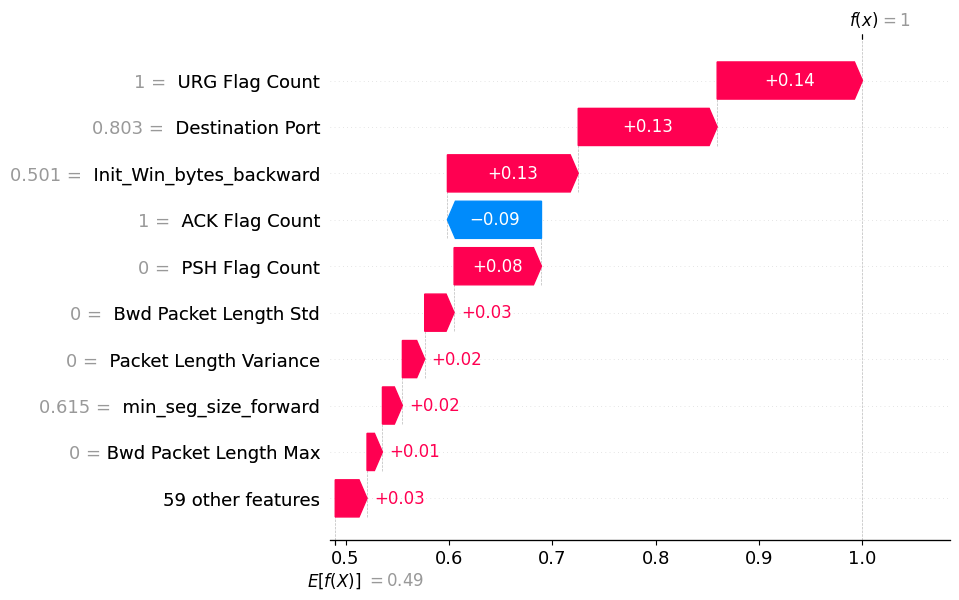

In [14]:
# plot explanations from bengin class
benign_classes = np.array(y_test[y_test['BENIGN'] == 1].index)
first_benign_index = benign_classes[0]
print(first_benign_index)
shap.waterfall_plot(shap_values[first_benign_index])

#### Malicious Class

0


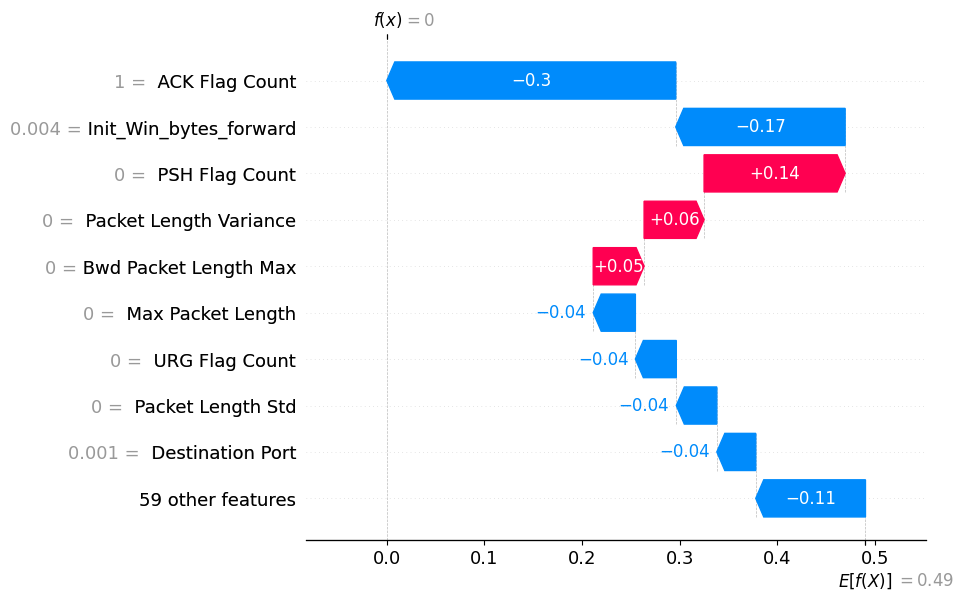

In [16]:
# plot explanations from malicious class
malicious_classes = np.array(y_test[y_test['ATTACK'] == 1].index)
first_malicious_index = malicious_classes[0]
print(first_malicious_index)
shap.waterfall_plot(shap_values[first_malicious_index])

### Global Models

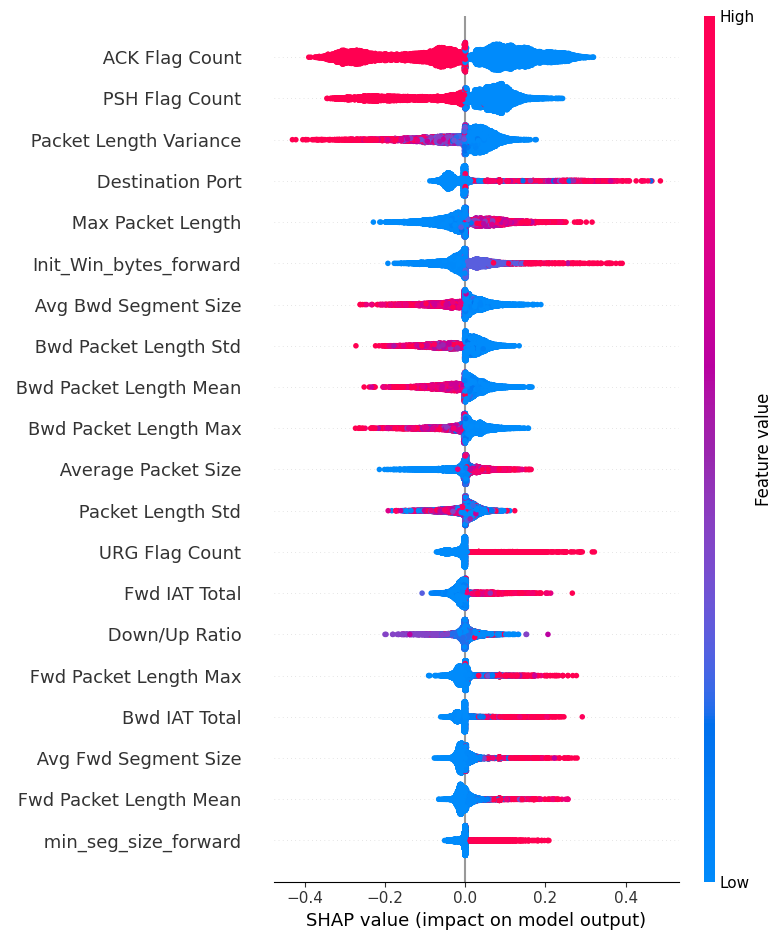

In [17]:
# summary plot
shap.summary_plot(shap_values, X_test)

#### Mean SHAP Values for Benign Class

Shap values shape: (10000, 68)
Benign classes shape: (5042,)
Benign shape values shape: (5042, 68)
X_test shape: (10000, 68)


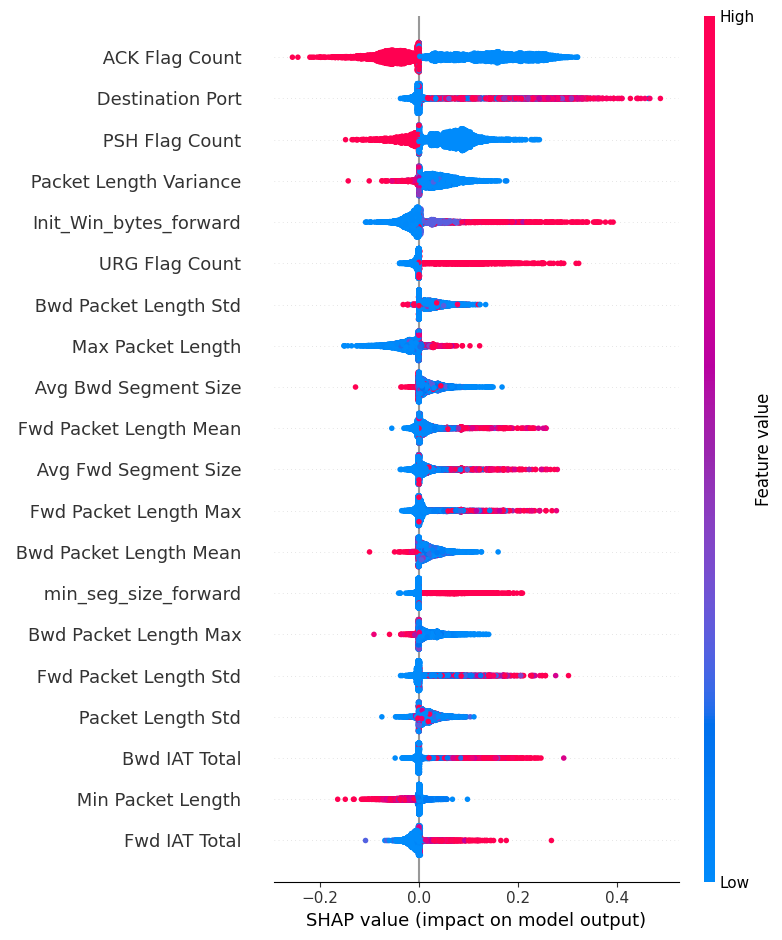

In [32]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Benign classes shape: {benign_classes.shape}")

benign_shape_values = shap_values[benign_classes]
print(f"Benign shape values shape: {benign_shape_values.shape}")
print(f"X_test shape: {X_test.shape}")
shap.summary_plot(benign_shape_values, X_test.iloc[benign_classes])

#### Mean SHAP Values for Malicious Class

Shap values shape: (10000, 68)
Malicious classes shape: (4958,)
Malicious shape values shape: (4958, 68)
X_test shape: (10000, 68)


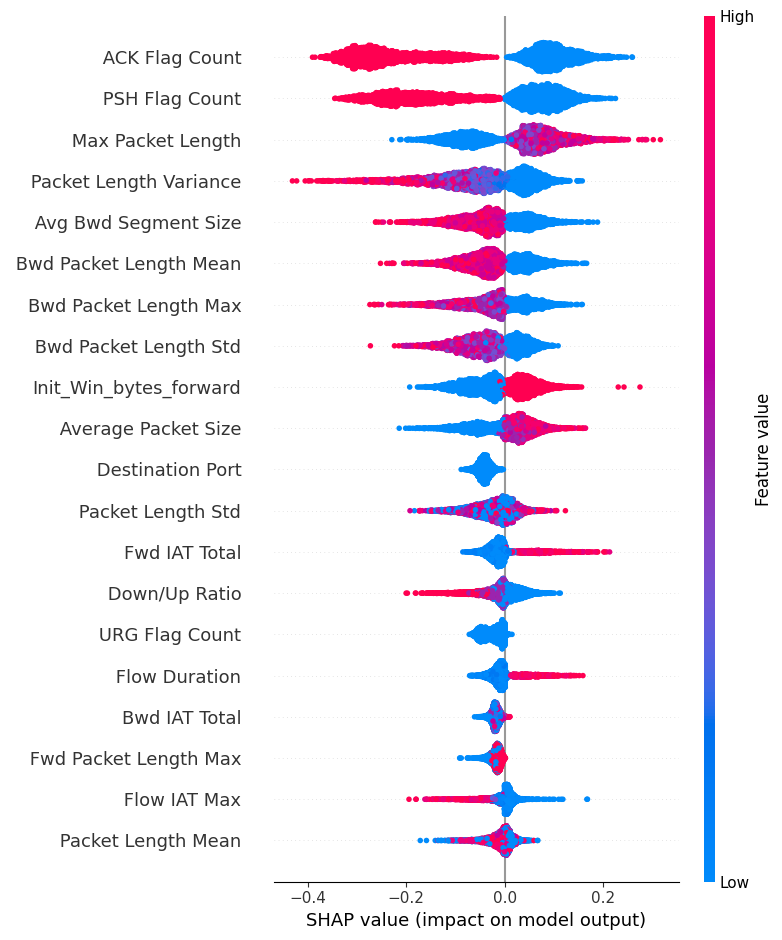

In [33]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Malicious classes shape: {malicious_classes.shape}")

malicious_shape_values = shap_values[malicious_classes]
print(f"Malicious shape values shape: {malicious_shape_values.shape}")
print(f"X_test shape: {X_test.shape}")
shap.summary_plot(malicious_shape_values, X_test.iloc[malicious_classes])


--- 

# Adversarial Explanations

## Load Adversarial Data Samples

In [11]:
# load adversarial sample
# X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_fgsm_poc.csv")
X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_cw_poc.csv")
# X_test_adv_hsj = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")
print(X_test_adv_cw.shape)

(2500, 68)


## Check Performance

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy without attack: {accuracy * 100:.2f}%')

# loss_adv_fgsm, accuracy_adv_fgsm = model.evaluate(X_test_adv_fgsm, y_test)
# print(f'Accuracy on fgsm attack: {accuracy_adv_fgsm * 100:.2f}%')

loss_adv_cw, accuracy_adv_cw = model.evaluate(X_test_adv_cw, y_test)
print(f'Accuracy on cw attack: {accuracy_adv_cw * 100:.2f}%')

# loss_adv_hsj, accuracy_adv_hop_skip_jump = model.evaluate(X_test_adv_hsj, y_test)
# print(f'Accuracy on hop_skip_jump attack: {accuracy_adv_hop_skip_jump * 100:.2f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9974 - loss: 0.0064     
Accuracy without attack: 99.72%
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8191 - loss: 0.6400
Accuracy on cw attack: 81.56%


## Generate Explanations on Adversarial Data

In [13]:
# FGSM Attack
# adv_explainer_fgsm = shap.Explainer(model, X_test_adv_fgsm, feature_names=X_test_adv_fgsm.columns)
# adv_shap_values_fgsm = adv_explainer_fgsm(X_test_adv_fgsm)
# print(adv_shap_values_fgsm.shape)

# CW Attack
adv_explainer_cw = shap.Explainer(model, X_test_adv_cw, feature_names=X_test_adv_cw.columns)
adv_shap_values_cw = adv_explainer_cw(X_test_adv_cw)
print(adv_shap_values_cw.shape)

# Hop-Skip-Jump Attack
# adv_explainer_hsj = shap.Explainer(model, X_test_adv_hsj, feature_names=X_test_adv_hsj.columns)
# adv_shap_values_hsj = adv_explainer_hsj(X_test_adv_hsj)
# print(adv_shap_values_hsj.shape)

PermutationExplainer explainer: 2501it [02:28, 15.68it/s]                          


(2500, 68, 2)


In [14]:
# convert shap values to correct format

# print("Convert FGSM shap values...")
# print(adv_shap_values_fgsm.shape) # one shap value per feature per sample per class
# adv_shap_values_fgsm = adv_shap_values_fgsm[:, :, 0] # 1 == Benign, 0 == Malicious
# print(adv_shap_values_fgsm.shape) # one shap value per feature per sample

print("Convert CW shap values...")
print(adv_shap_values_cw.shape) # one shap value per feature per sample per class
adv_shap_values_cw = adv_shap_values_cw[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values_cw.shape) # one shap value per feature

# print("Convert Hop-Skip-Jump shap values...")
# print(adv_shap_values_hsj.shape) # one shap value per feature per sample per class
# adv_shap_values_hsj = adv_shap_values_hsj[:, :, 0] # 1 == Benign, 0 == Malicious
# print(adv_shap_values_hsj.shape) # one shap value per feature per sample

Convert CW shap values...
(2500, 68, 2)
(2500, 68)


## Store Adversarial Explanations

In [15]:
# adv_shap_values_fgsm_df = pd.DataFrame(adv_shap_values_fgsm.values, columns=feature_names)
adv_shap_values_cw_df = pd.DataFrame(adv_shap_values_cw.values, columns=feature_names)
# adv_shap_values_hop_skip_jump_df = pd.DataFrame(adv_shap_values_hsj.values, columns=feature_names)

# adv_shap_values_fgsm_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_fgsm_poc.csv", index=False)
adv_shap_values_cw_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_cw_poc.csv", index=False)
# adv_shap_values_hop_skip_jump_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv", index=False)

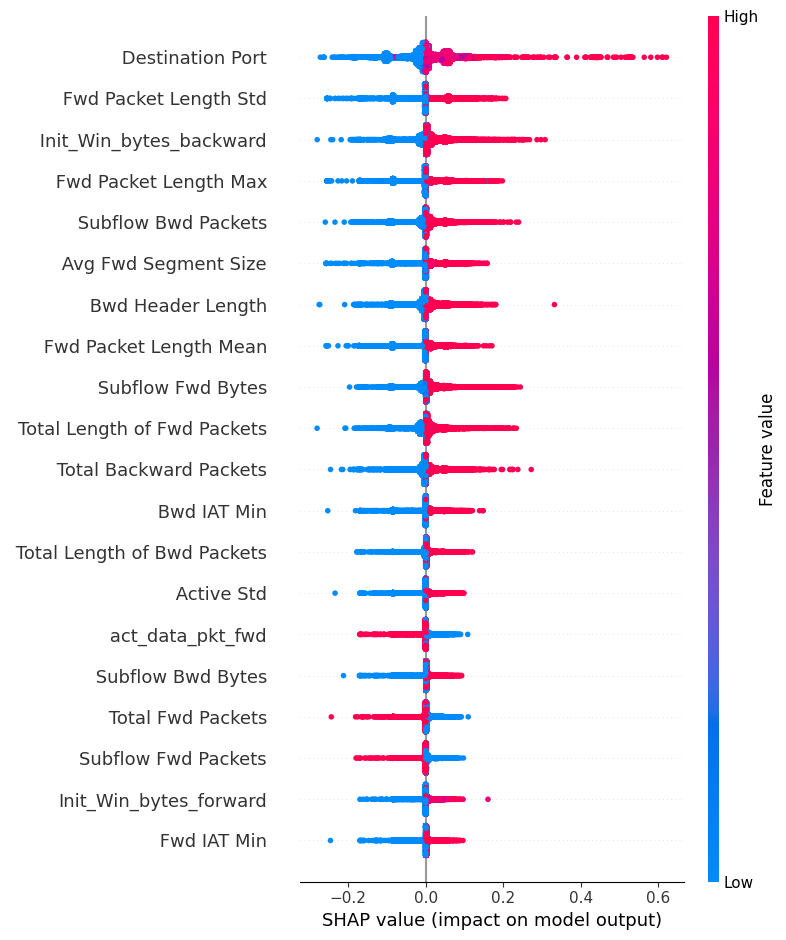

In [34]:
shap.summary_plot(adv_shap_values_fgsm, X_test_adv_fgsm)

---
## Identifying Samples Misclassified Due to Adversarial Attacks

In [37]:
print("Correct Labels:")
y_test_np = np.array(y_test).argmin(axis=1)
print(f"Prediction: {y_test_np[:20]}")

# predict samples
print("Prediction on clean samples...")
y_pred = model.predict(X_test)
print("convert to binary...")
print(y_pred.shape)
y_pred = y_pred.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(y_pred.shape)
print(f"Prediction: {y_pred[:20]}")

# print("Prediction on FGSM attacked samples...")
# y_pred_adv_fgsm = model.predict(X_test_adv_fgsm)
# y_pred_adv_fgsm = y_pred_adv_fgsm.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
# print(f"Prediction: {y_pred_adv_fgsm[:20]}")

print("Prediction on CW attacked samples...")
y_pred_adv_cw = model.predict(X_test_adv_cw)
y_pred_adv_cw = y_pred_adv_cw.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_cw[:20]}")

# print("Prediction on Hop Skip Jump attacked samples...")
# y_pred_adv_hsj = model.predict(X_test_adv_hsj)
# y_pred_adv_hsj = y_pred_adv_hsj.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
# print(f"Prediction: {y_pred_adv_hsj[:20]}")

Correct Labels:
Prediction: [0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0]
Prediction on clean samples...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
convert to binary...
(10000, 2)
(10000,)
Prediction: [0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0]
Prediction on FGSM attacked samples...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Prediction: [1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1]


In [ ]:
# Find correctly classified indices
correctly_classified_indices = np.where(y_test_np == y_pred)[0]

In [ ]:
# # find misclassified samples due to FGSM attack

# # Find indices where attack misclassifies a `1` as `0`
# false_negative_indices_fgsm = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_fgsm[correctly_classified_indices] == 0)
# ]
# print(f"FGSM: Misclassify Begnin Traffic as Malicious: {false_negative_indices_fgsm[:10]}")
# print(f"Size: {np.size(false_negative_indices_fgsm)}")

# # Find indices where attack misclassifies a `0` as `1`
# false_positive_indices_fgsm = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_fgsm[correctly_classified_indices] == 1)
# ]
# print(f"FGSM: Misclassify Malicious Traffic as Benign: {false_positive_indices_fgsm[:10]}")
# print(f"Size: {np.size(false_positive_indices_fgsm)}")

# # all misclassified samples
# misclassified_adversarial_indices = np.concat([false_negative_indices_fgsm, false_positive_indices_fgsm])
# print(f"FGSM: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

In [22]:
# find misclassified samples due to CW attack

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_cw[correctly_classified_indices] == 0)
]
print(f"CW: Misclassify Begnin Traffic as Malicious: {false_negative_indices_cw[:10]}")
print(f"Size: {np.size(false_negative_indices_cw)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_cw[correctly_classified_indices] == 1)
]
print(f"CW: Misclassify Malicious Traffic as Benign: {false_positive_indices_cw[:10]}")
print(f"Size: {np.size(false_positive_indices_cw)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_cw, false_positive_indices_cw])
print(f"CW: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

In [23]:
# # find misclassified samples due to Hop Skip Jump attack

# # Find indices where attack misclassifies a `1` as `0`
# false_negative_indices_hsj = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_hsj[correctly_classified_indices] == 0)
# ]
# print(f"Hop Skip Jump: Misclassify Begnin Traffic as Malicious: {false_negative_indices_hsj[:10]}")
# print(f"Size: {np.size(false_negative_indices_hsj)}")

# # Find indices where attack misclassifies a `0` as `1`
# false_positive_indices_hsj = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_hsj[correctly_classified_indices] == 1)
# ]
# print(f"Hop Skip Jump: Misclassify Malicious Traffic as Benign: {false_positive_indices_hsj[:10]}")
# print(f"Size: {np.size(false_positive_indices_hsj)}")

# # all misclassified samples
# misclassified_adversarial_indices = np.concat([false_negative_indices_hsj, false_positive_indices_hsj])
# print(f"Hop Skip Jump: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

Hop Skip Jump: Misclassify Begnin Traffic as Malicious: []
Size: 0
Hop Skip Jump: Misclassify Malicious Traffic as Benign: [ 9 14 15 20 31 40 61 70 71 78]
Size: 368
Hop Skip Jump: All Missclassified Samples after Attack: 368


## Plot Sample Explanations that is Misclassified as Benign due to Attack

In [40]:
# find matching indices where FGSM and CW attack triggers misclassification of a malicious samples as benign
# matching_indices = np.intersect1d(false_positive_indices_fgsm, false_positive_indices_hsj)
matching_indices = false_positive_indices_cw
print(f"Matching indices: {matching_indices[:10]}")

Matching indices: [ 0  2  4  5  7  9 11 12 13 15]


### Revert Normalization for better Visualization

In [44]:
min_max_df = pd.read_csv('../CICIDS2017/preprocessed/min_max_values.csv')
min_max = min_max_df.to_numpy()
# get second column (min values) from three column array
min_values = min_max[:, 1]
max_values = min_max[:, 2]

def revert_min_max_normalization(data):
    return data * (max_values - min_values) + max_values

# load feature_types.npy
feature_types = np.load('../CICIDS2017/preprocessed/feature_types.npy', allow_pickle=True)

def round_if_int(data, index):
    for i, col_type in enumerate(feature_types):
        if col_type == np.int64:
            data[index, i] = int(round(data[index, i]))
    return data

### Correct Classified

Index: 15
Prediction: 0 | 0 == Malicious, 1 == Benign


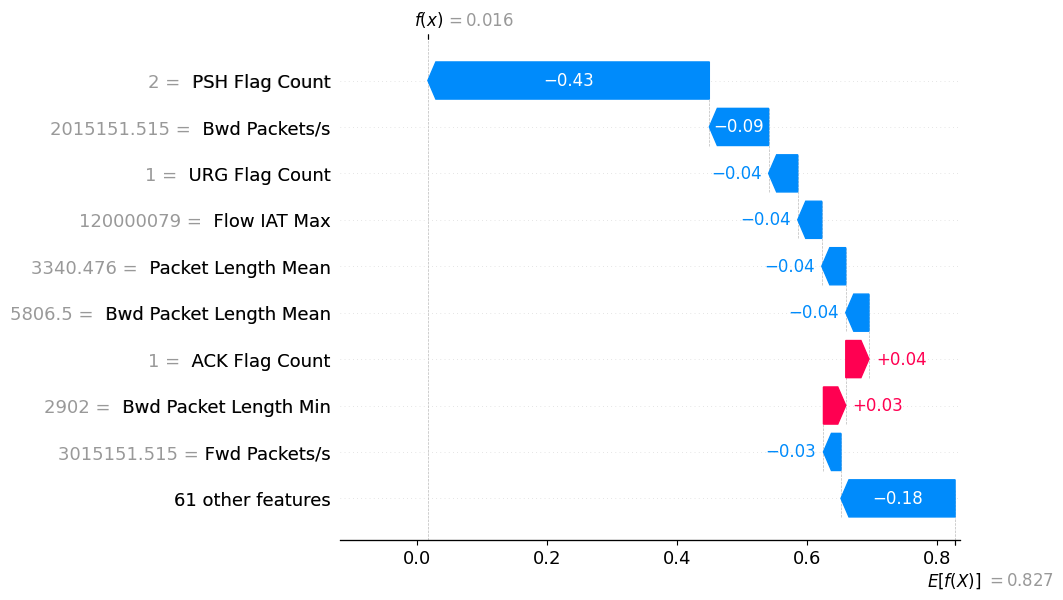

In [85]:
index = matching_indices[0]
print(f"Index: {index}")
print(f"Prediction: {y_pred[index]} | 0 == Malicious, 1 == Benign")

# revert normalization of shap_values.data
data = revert_min_max_normalization(shap_values.data)
shap_values.data = round_if_int(data, index)

# plot explanation from correct classified samples
shap.waterfall_plot(shap_values[index])

### Misclassified due to Attack - Single Explanation

Index: 15
Prediction: 1 | 0 == Malicious, 1 == Benign


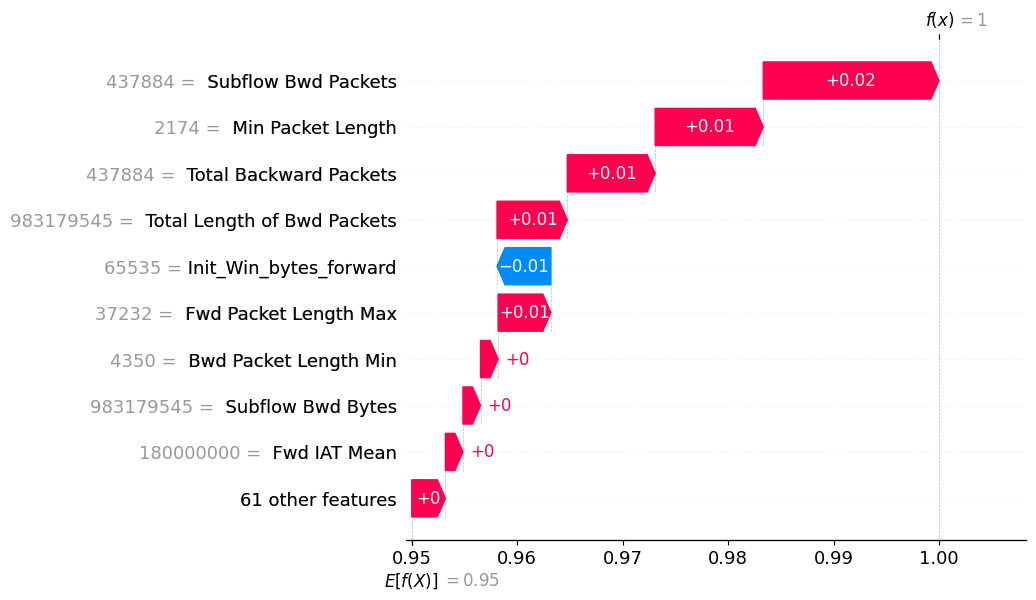

In [86]:
# # FGSM attack
# print(f"Index: {index}")
# print(f"Prediction: {y_pred_adv_fgsm[index]} | 0 == Malicious, 1 == Benign")

# # revert normalization of shap_values.data
# data = revert_min_max_normalization(adv_shap_values_fgsm.data)
# adv_shap_values_fgsm.data = round_if_int(data, index)

# # plot explanations from misclassified samples
# shap.waterfall_plot(adv_shap_values_fgsm[index])

Index: 15
Prediction: 1 | 0 == Malicious, 1 == Benign


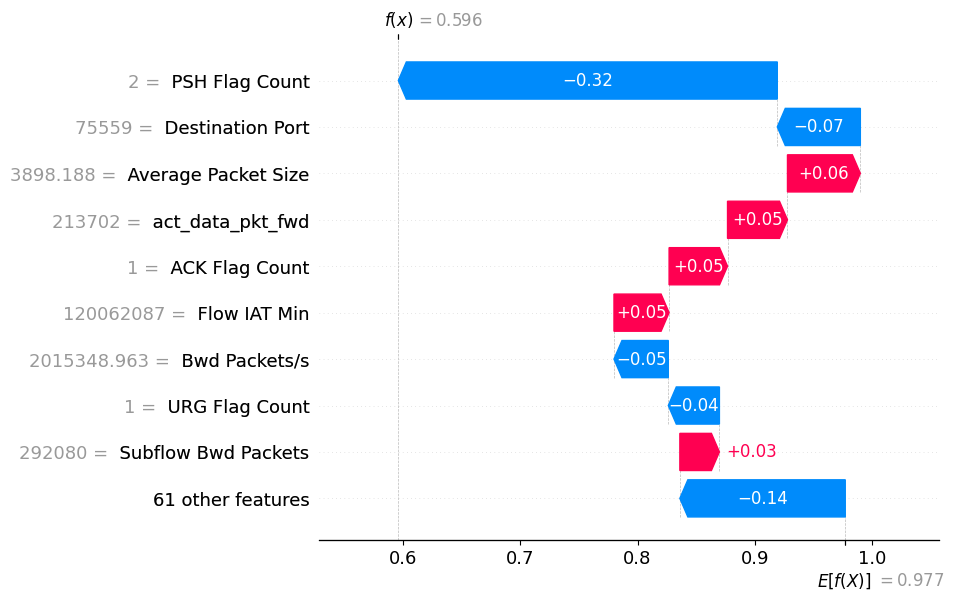

In [87]:
# # Hop Skip Jump attack
# print(f"Index: {index}")
# print(f"Prediction: {y_pred_adv_hsj[index]} | 0 == Malicious, 1 == Benign")

# # revert normalization of shap_values.data
# data = revert_min_max_normalization(adv_shap_values_hsj.data)
# adv_shap_values_hsj.data = round_if_int(data, index)

# # plot explanations from misclassified samples
# shap.waterfall_plot(adv_shap_values_hsj[index])

Index: 15
Prediction: 1 | 0 == Malicious, 1 == Benign


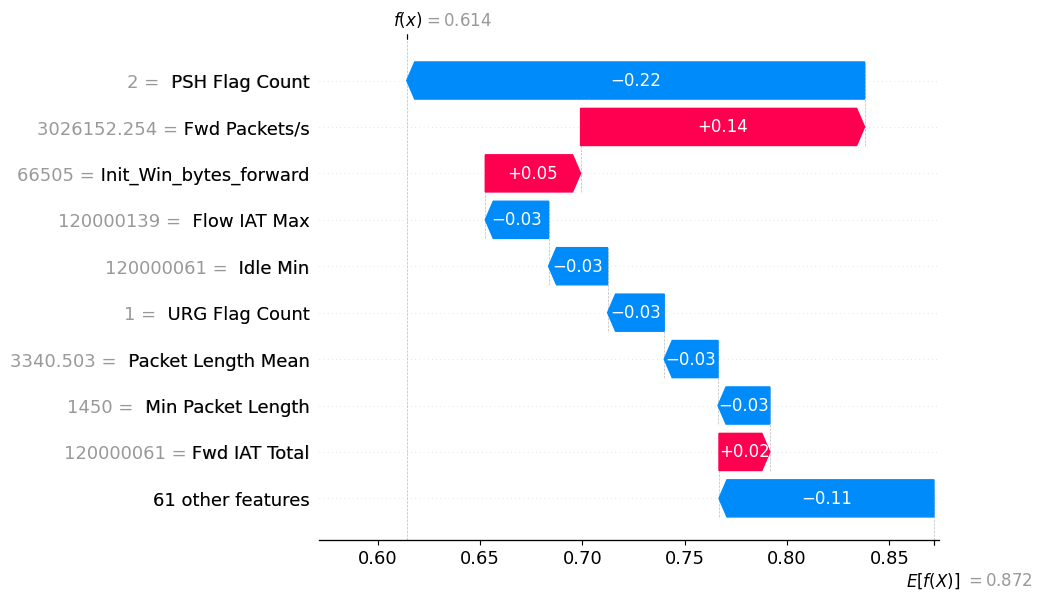

In [88]:
# # CW attack
# print(f"Index: {index}")
# print(f"Prediction: {y_pred_adv_cw[index]} | 0 == Malicious, 1 == Benign")

# # plot explanations from misclassified samples
# shap.waterfall_plot(adv_shap_values_cw[index])

## ***Finding***: *Features with the highest SHAP Values are different! -> Explanation do not match to prediction!*

## Compare Values

In [29]:
# local_fgsm_df = X_test_adv_fgsm.iloc[index]
#print(local_fgsm_df.to_string())

In [30]:
# local_cw_df = X_test_adv_hsj.iloc[index]
#print(local_cw_df.to_string())

In [31]:
local_df = X_test.iloc[index]
#print(local_df.to_string())

## Global SHAP Distribution of Attacked System

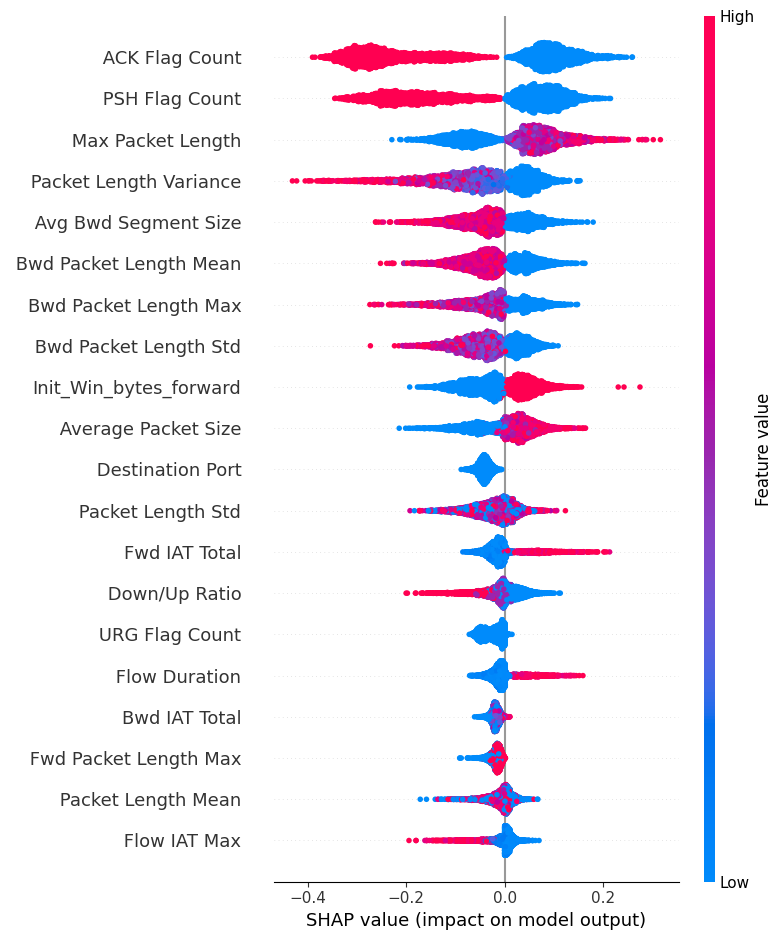

In [ ]:
# plot normal shap values for false positive misclassified samples
X_test_np = np.array(X_test)
shap.summary_plot(shap_values[false_positive_indices_cw], X_test_np[false_positive_indices_cw])

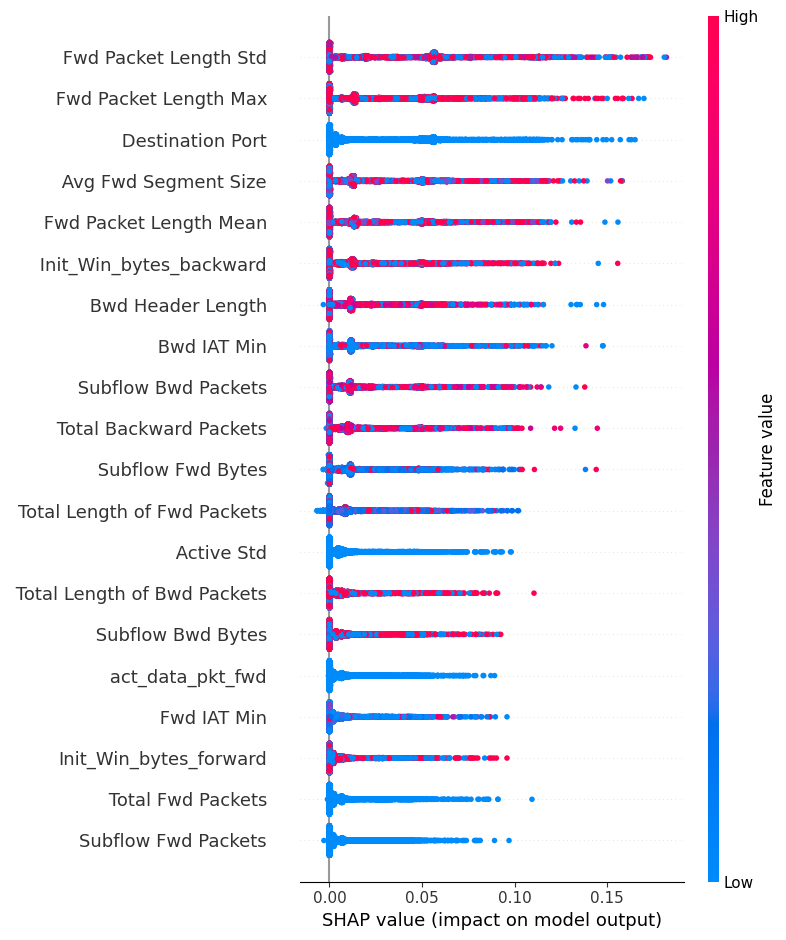

In [ ]:
# plot FGSM attack shap values for false positive misclassified samples
X_test_adv_fgsm_np = np.array(X_test_adv_cw)
shap.summary_plot(adv_shap_values_cw[false_positive_indices_cw], X_test_adv_fgsm_np[false_positive_indices_cw])

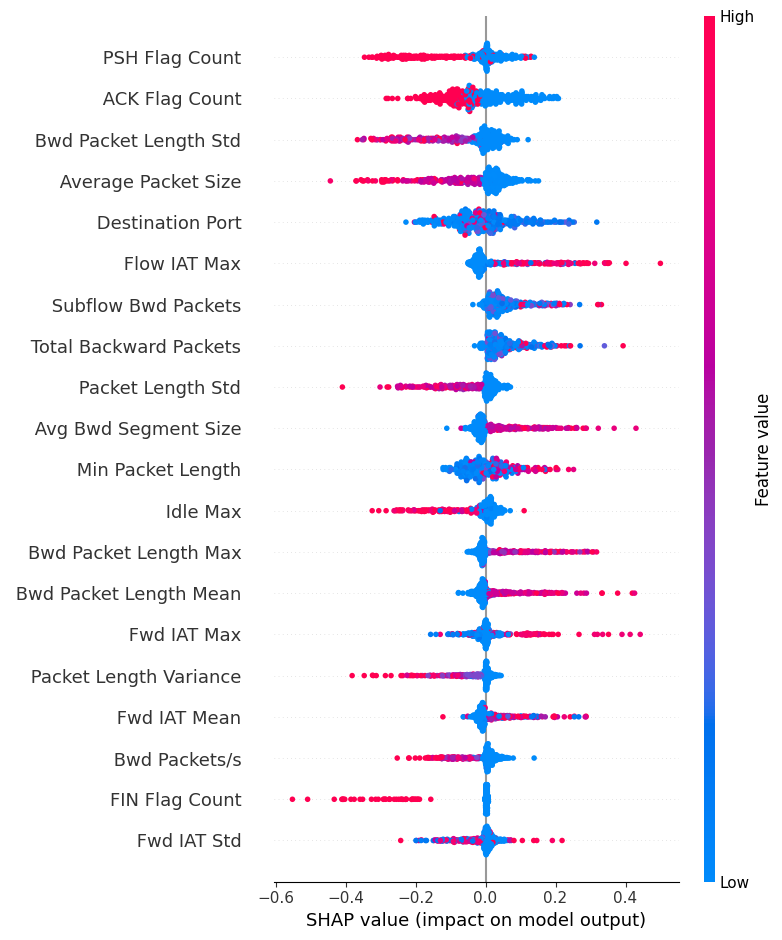

In [34]:
# plot HSJ attack shap values for false positive misclassified samples
# X_test_adv_hsj_np = np.array(X_test_adv_hsj)
# shap.summary_plot(adv_shap_values_hsj[false_positive_indices_hsj], X_test_adv_hsj_np[false_positive_indices_hsj])

## Global Plot of Benign Samples

[ 0  1  2  3  4  6  7  8  9 10]


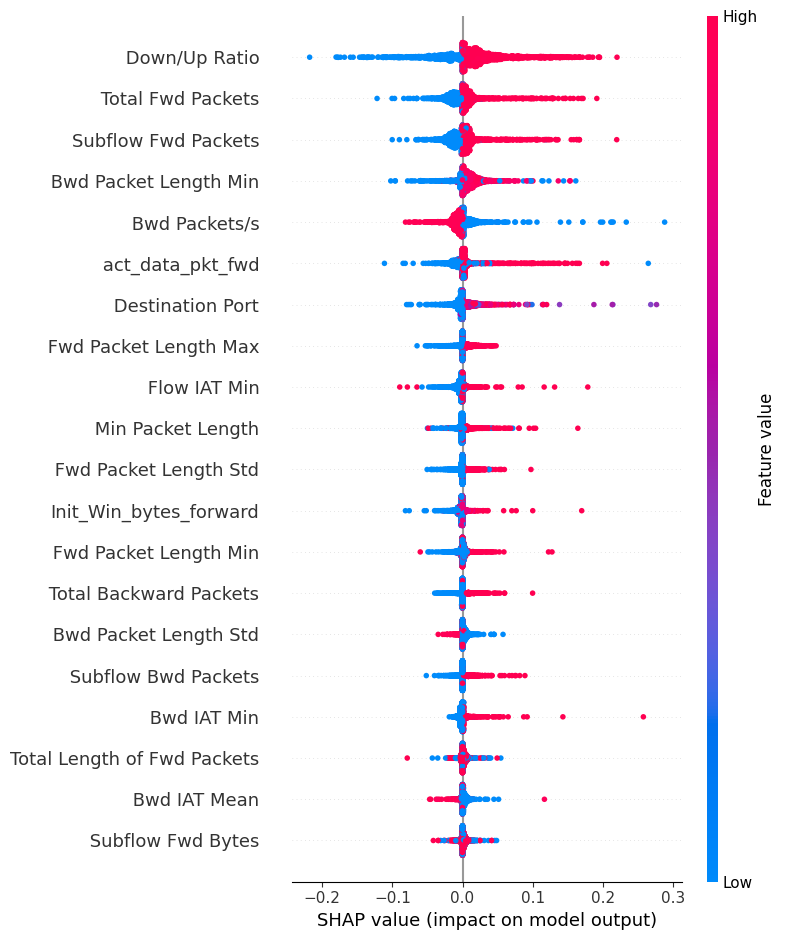

In [35]:
# get benign classes from FGSM attack
benign_classes_cw = np.where(y_pred_adv_cw == 1)[0]
print(benign_classes_cw[:10])

shap.summary_plot(adv_shap_values_cw[benign_classes_cw], X_test_adv_cw.iloc[benign_classes_cw])

[0 1 2 3 4 5 6 7 8 9]


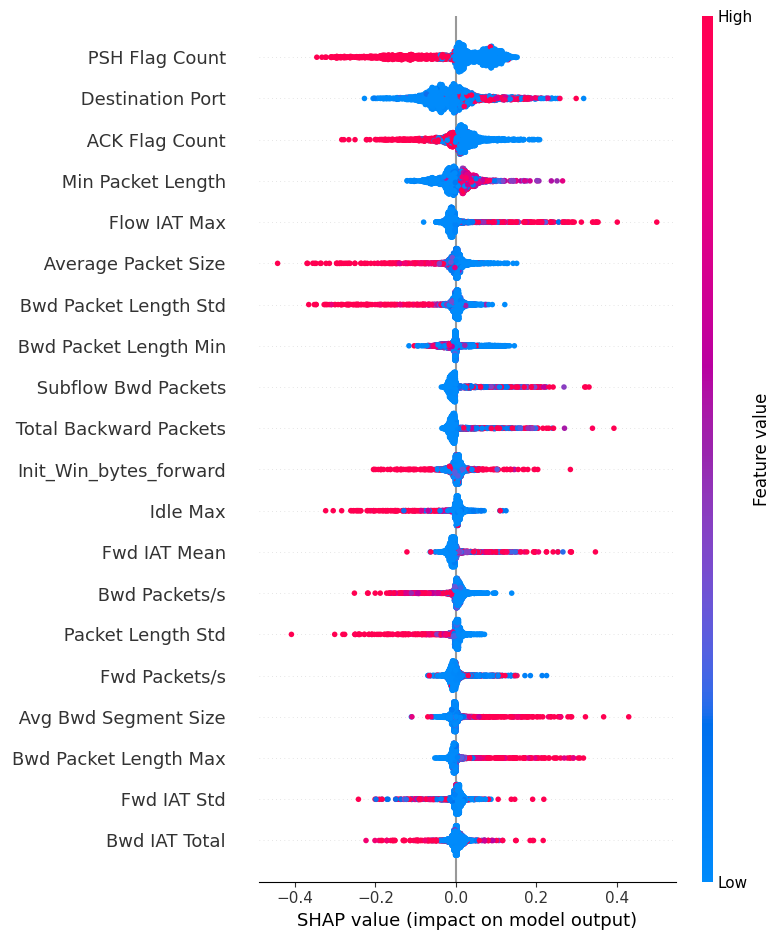

In [38]:
# # get benign classes from HSJ attack
# benign_classes_hsj = np.where(y_pred_adv_hsj == 1)[0]
# print(benign_classes_hsj[:10])

# shap.summary_plot(adv_shap_values_hsj[benign_classes_hsj], X_test_adv_hsj.iloc[benign_classes_hsj])

[ 0  1  2  3  4  5  6  7  8 10]


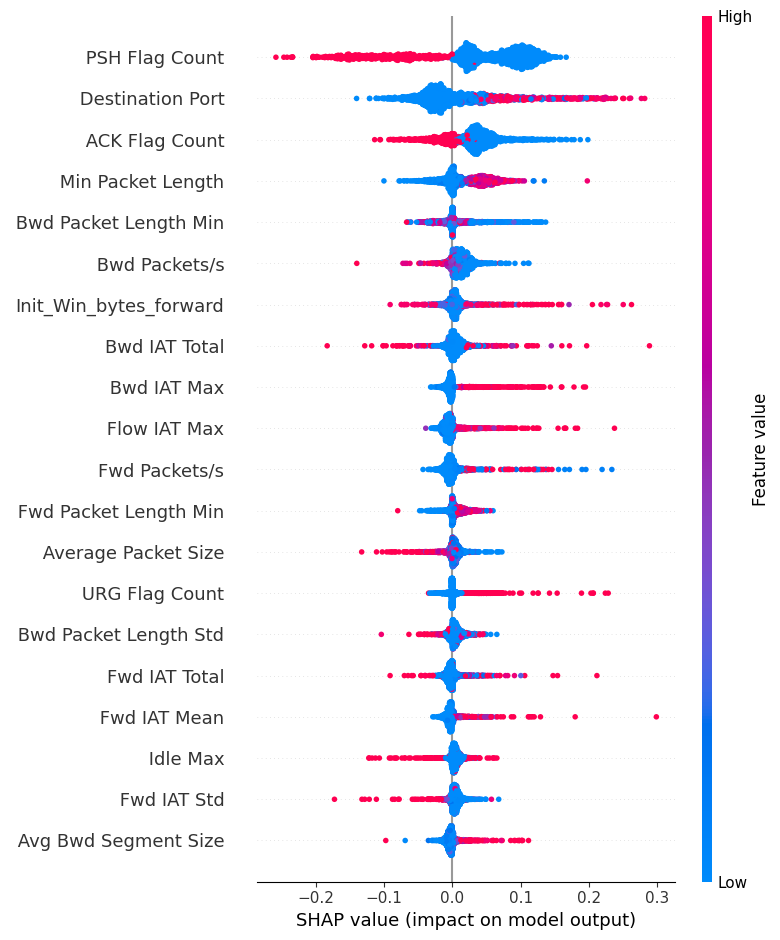

In [37]:
# get benign classes from normal prediction
benign_classes = np.where(y_pred == 1)[0]
print(benign_classes[:10])

shap.summary_plot(shap_values[benign_classes], X_test.iloc[benign_classes])